### Ckecking the GPU :

In [1]:
import tensorflow as tf 

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.__version__

'2.1.0'

In [6]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


### Import libraries :

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import cv2
%matplotlib inline

### Import data :

In [9]:
infile = open('C:/Users/Saberi/Downloads/train.pickle','rb')
train_dict = pickle.load(infile)
infile.close()

infile = open('C:/Users/Saberi/Downloads/test.pickle','rb')
test_dict = pickle.load(infile)
infile.close()

infile = open('C:/Users/Saberi/Downloads/valid.pickle','rb')
valid_dict = pickle.load(infile)
infile.close()

sign=pd.read_csv('C:/Users/Saberi/Downloads/label_names.csv')
sign['SignName'] = (sign['SignName']).astype("string")

In [10]:
sign.head(4)

ClassId              SignName
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)

### Getting to know the data :

In [11]:
train_dict.keys()

dict_keys(['coords', 'labels', 'features', 'sizes'])

Our images are in the 'features' key.

In [12]:
train_dict['features'].shape

(34799, 32, 32, 3)

In [13]:
pd.DataFrame(train_dict['labels']).info()
#we have no null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34799 entries, 0 to 34798
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       34799 non-null  uint8
dtypes: uint8(1)
memory usage: 34.1 KB


### Preparing the data for  our network :

a) preparing the training data

In [14]:
### gray version of the images
train_x_gray=np.array(tf.image.rgb_to_grayscale(train_dict['features'])) 
### rgb version of the images
train_x_rgb=train_dict['features']
### our numeric labels
train_y=train_dict['labels'].reshape(len(train_dict['labels']),1) 

print("shape of the gray training data : ",train_x_gray.shape)
print("shape of the rgb training data : ",train_x_rgb.shape)
print("shape of the training labels : ",train_y.shape)

shape of the gray training data :  (34799, 32, 32, 1)
shape of the rgb training data :  (34799, 32, 32, 3)
shape of the training labels :  (34799, 1)


b) preparing the validation data :

In [15]:
### gray version of the images
valid_x_gray=np.array(tf.image.rgb_to_grayscale(valid_dict['features'])) 
### rgb version of the images
valid_x_rgb=valid_dict['features'] 
### our numeric labels
valid_y=valid_dict['labels'].reshape(len(valid_dict['labels']),1)

print("shape of the gray valid data : ",valid_x_gray.shape)
print("shape of the rgb valid data : ",valid_x_rgb.shape)
print("shape of the valid labels : ",valid_y.shape)

shape of the gray valid data :  (4410, 32, 32, 1)
shape of the rgb valid data :  (4410, 32, 32, 3)
shape of the valid labels :  (4410, 1)


c) preparing the test data :

In [16]:
### gray version of the images
test_x_gray=np.array(tf.image.rgb_to_grayscale(test_dict['features'])) 
### rgb version of the images
test_x_rgb=test_dict['features'] 
### our numeric labels
test_y=test_dict['labels'].reshape(len(test_dict['labels']),1)

print("shape of the gray test data : ",test_x_gray.shape)
print("shape of the rgb test data : ",test_x_rgb.shape)
print("shape of the test labels : ",test_y.shape)

shape of the gray test data :  (12630, 32, 32, 1)
shape of the rgb test data :  (12630, 32, 32, 3)
shape of the test labels :  (12630, 1)


#### coverting the response variable to one-hot encode format :

In [17]:
from tensorflow.keras.utils import to_categorical

train_y=to_categorical(train_y,sign.shape[0])

valid_y=to_categorical(valid_y,sign.shape[0])

test_y=to_categorical(test_y,sign.shape[0])

print(train_y.shape)
print(valid_y.shape)
print(test_y.shape)

(34799, 43)
(4410, 43)
(12630, 43)


____________________________________________________________________________________

### Applying histogram equalizer on train/test/validation sets :

In [18]:
img=test_x_rgb[0,:,:,:]

In [19]:
def histogram_equalization(df):
    img_out=df.copy()
    for i in range(len(df)):
        img=df[i,:,:,:]
        # split color channels
        b,g,r = cv2.split(img)
        h_b, bin_b = np.histogram(b.flatten(), 256, [0, 256])
        h_g, bin_g = np.histogram(g.flatten(), 256, [0, 256])
        h_r, bin_r = np.histogram(r.flatten(), 256, [0, 256])
        # calculate cdf    
        cdf_m_b = np.cumsum(h_b)  
        cdf_m_g = np.cumsum(h_g)
        cdf_m_r = np.cumsum(h_r)
    

        cdf_m_b = (cdf_m_b - cdf_m_b.min())*255/(cdf_m_b.max()-cdf_m_b.min())
        cdf_final_b = np.ma.filled(cdf_m_b,0).astype('uint8')
  

        cdf_m_g = (cdf_m_g - cdf_m_g.min())*255/(cdf_m_g.max()-cdf_m_g.min())
        cdf_final_g = np.ma.filled(cdf_m_g,0).astype('uint8')
    
        cdf_m_r = (cdf_m_r - cdf_m_r.min())*255/(cdf_m_r.max()-cdf_m_r.min())
        cdf_final_r = np.ma.filled(cdf_m_r,0).astype('uint8')
    
        # merge the images in the three channels
        img_b = cdf_final_b[b]
        img_g = cdf_final_g[g]        
        img_r = cdf_final_r[r]
  
        img_out[i,:,:,:]=cv2.merge((img_b, img_g, img_r))
    
    
    return img_out

equalize train/test/validation rgb images :

In [20]:
eq_train_x_rgb=histogram_equalization(train_x_rgb)
eq_valid_x_rgb=histogram_equalization(valid_x_rgb)
eq_test_x_rgb=histogram_equalization(test_x_rgb)

make equalized gray images from equalized rgb images :

In [21]:
eq_train_x_gray=np.array(tf.image.rgb_to_grayscale(eq_train_x_rgb))
eq_valid_x_gray=np.array(tf.image.rgb_to_grayscale(eq_valid_x_rgb))
eq_test_x_gray=np.array(tf.image.rgb_to_grayscale(eq_test_x_rgb))

## Visualizing some of the data in RGB and gray format without histogram equalization :

##### writing a function to randomly plot 9 images of gray or rgb pictures regarding to a specified label:

In [22]:
import random
def get_rgb_pic(i,df):
    random.seed(4)
    samp=np.array(random.sample(list(df[train_dict['labels']==i]),9))
    fig, axes = plt.subplots(nrows=1, ncols=9,figsize=(15,15))
    for j in range(0,9):
        img = samp[j]
        axes[j].imshow(img)
        axes[j].axis('off')
    a=sign[sign['ClassId']==i]['SignName'].values[0]
    axes[4].set_title(f"some pictures of class {i} which is {a} sign",loc='center')   

    plt.show()

def get_gray_pic(i,df):
    random.seed(4)
    samp=np.array(random.sample(list(df[train_dict['labels']==i]),9))
    fig, axes = plt.subplots(nrows=1, ncols=9,figsize=(15,15))
    for j in range(0,9):
        img = samp[j,:,:,0]
        axes[j].imshow(img)
        axes[j].axis('off')
    a=sign[sign['ClassId']==i]['SignName'].values[0]
    axes[4].set_title(f"some pictures of class {i} which is {a} sign",loc='center')    

    plt.show() 

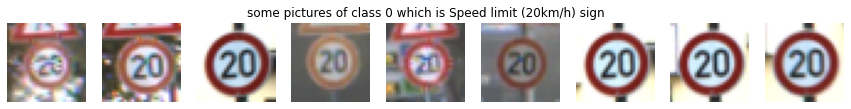

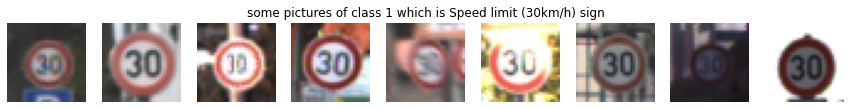

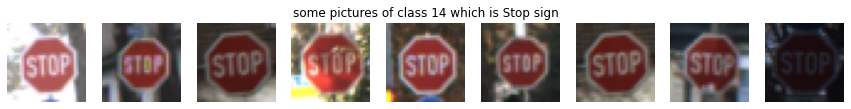

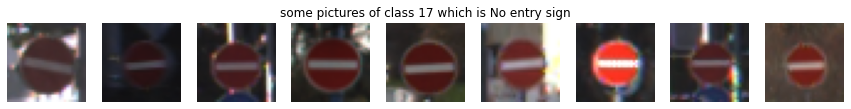

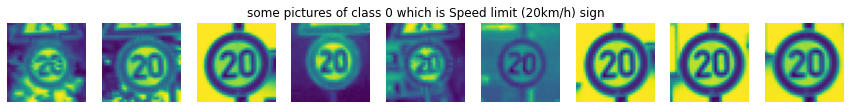

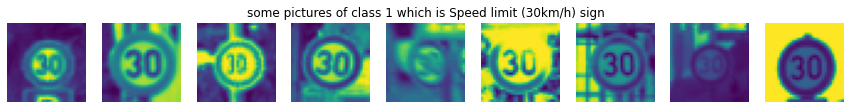

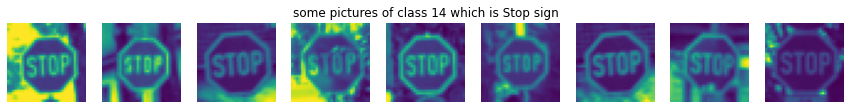

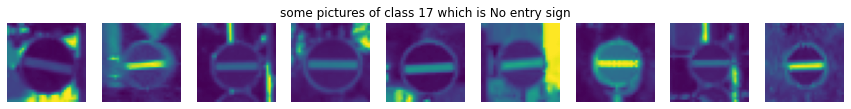

In [23]:
###RGB
get_rgb_pic(0,train_x_rgb)
get_rgb_pic(1,train_x_rgb)
get_rgb_pic(14,train_x_rgb)
get_rgb_pic(17,train_x_rgb)
###gray
get_gray_pic(0,train_x_gray)
get_gray_pic(1,train_x_gray)
get_gray_pic(14,train_x_gray)
get_gray_pic(17,train_x_gray)

As you can see, some of the pictures are really dark and unclear. We will solve this issue by equalizing the pictures.

______________

## Visualizing some of the data in RGB and gray format with histogram equalization :

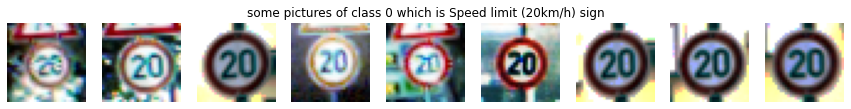

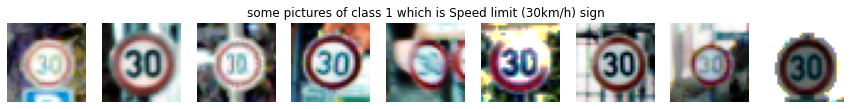

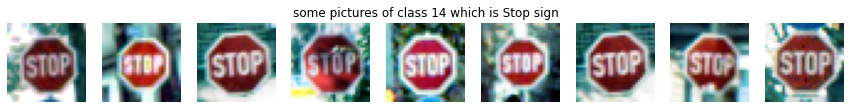

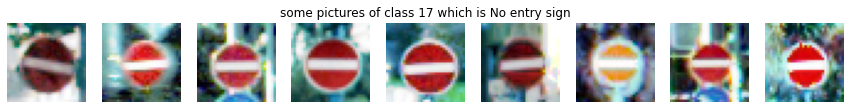

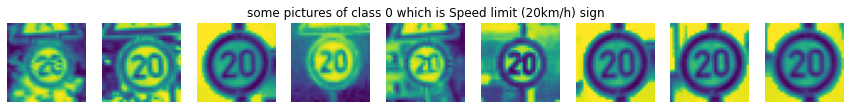

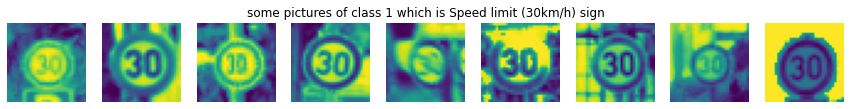

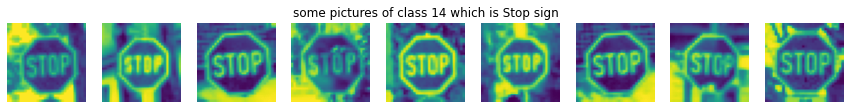

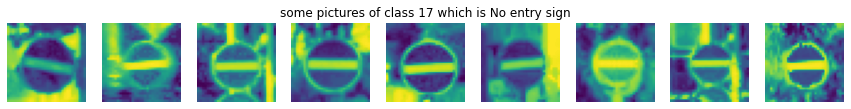

In [24]:
###RGB
get_rgb_pic(0,eq_train_x_rgb)
get_rgb_pic(1,eq_train_x_rgb)
get_rgb_pic(14,eq_train_x_rgb)
get_rgb_pic(17,eq_train_x_rgb)
###gray
get_gray_pic(0,eq_train_x_gray)
get_gray_pic(1,eq_train_x_gray)
get_gray_pic(14,eq_train_x_gray)
get_gray_pic(17,eq_train_x_gray)

Now that we've applied histogram equalizer technique, the pictures are more clear.

__________________

### Checking the distribution of labels :

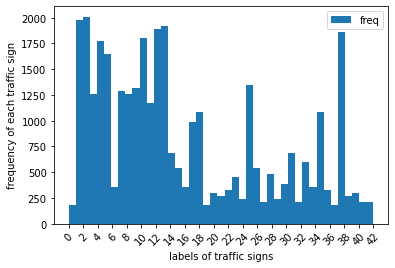

In [25]:
plt.hist(train_dict['labels'],label='freq',bins=43)
plt.legend(loc="upper right")
plt.xticks(range(0,43,2),rotation=45)
plt.xlabel('labels of traffic signs')
plt.ylabel('frequency of each traffic sign')
plt.show()

As you can see, our classes are imbalanced and one solution is to specify weights regarding the above distribution.

#### Dealing with imbalanced classes :

In [26]:
###counting the frequency of each label in the training dataset
x=pd.DataFrame(np.bincount(train_dict['labels']))
x.T

0     1     2     3     4     5    6     7     8     9   ...   33   34  \
0  180  1980  2010  1260  1770  1650  360  1290  1260  1320  ...  599  360   

     35   36   37    38   39   40   41   42  
0  1080  330  180  1860  270  300  210  210  

[1 rows x 43 columns]

In [27]:
### defining a function who will alocate larger weights to smaller classes and vice versa.
def create_class_weight(x):
  class_weights={}
  for i in range(43):
    #calculate a weight regarding the frequency of each label. 
    #the below weight has a reverse relationship with the frequency of the label
    weight=(1/np.squeeze(x.iloc[i])) * (sum(x[0]))/len(x)
    class_weights[i]=weight
  return class_weights



In [28]:
#we will use it later on the .fit function in training
class_weights=create_class_weight(x)

#### Normalizing the image data :

In [29]:
### normalizing the equalized rgb photos
eq_train_x_rgb=eq_train_x_rgb /255.
eq_valid_x_rgb=eq_valid_x_rgb /255.
eq_test_x_rgb=eq_test_x_rgb  /255.
###normalizing the un-equalized rgb photos
train_x_rgb=train_x_rgb/255.
valid_x_rgb=valid_x_rgb/255.
test_x_rgb=test_x_rgb/255.

### normalizing the equalized gray photos
eq_train_x_gray=eq_train_x_gray /255.
eq_valid_x_gray=eq_valid_x_gray /255.
eq_test_x_gray=eq_test_x_gray   /255.

### normalizing the un-equalized gray photos
train_x_gray=train_x_gray/255.
valid_x_gray=valid_x_gray/255.
test_x_gray=test_x_gray/255.

In order to train our network better and avoid overfitting, we tend to use some data augmentation techniques to generate some diverse new images from the pictures we already have.

### Creating image generators for equalized images :

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##data generator for training data
datagen_t_g = ImageDataGenerator(  
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15) 

##data generator for validation data
datagen_v_g = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15)  

datagen_t_g.fit(eq_train_x_gray)
datagen_v_g.fit(eq_valid_x_gray)
###generating gray images
train_generator_gray_eq=datagen_t_g.flow(eq_train_x_gray,train_y,batch_size=32)
valid_generator_gray_eq=datagen_v_g.flow(eq_valid_x_gray,valid_y,batch_size=32)

##data generator for training data
datagen_t_rgb = ImageDataGenerator(  
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15) 

##data generator for validation data
datagen_v_rgb = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
      width_shift_range=0.1,
      height_shift_range=0.1,
    shear_range=0.15) 

###generating rgb images
datagen_t_rgb.fit(eq_train_x_rgb)
datagen_v_rgb.fit(eq_valid_x_rgb)

train_generator_rgb_eq=datagen_t_rgb.flow(eq_train_x_rgb,train_y,batch_size=32)
valid_generator_rgb_eq=datagen_v_rgb.flow(eq_valid_x_rgb,valid_y,batch_size=32)

### Creating image generators for un-equalized images :

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##data generator for training data
datagen_t_g = ImageDataGenerator(  
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15) 

##data generator for validation data
datagen_v_g = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15)  

datagen_t_g.fit(train_x_gray)
datagen_v_g.fit(valid_x_gray)
###generating gray images
train_generator_gray_un_eq=datagen_t_g.flow(train_x_gray,train_y,batch_size=32)
valid_generator_gray_un_eq=datagen_v_g.flow(valid_x_gray,valid_y,batch_size=32)

##data generator for training data
datagen_t_rgb = ImageDataGenerator(  
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15) 

##data generator for validation data
datagen_v_rgb = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
      width_shift_range=0.1,
      height_shift_range=0.1,
    shear_range=0.15) 

###generating rgb images
datagen_t_rgb.fit(train_x_rgb)
datagen_v_rgb.fit(valid_x_rgb)

train_generator_rgb_un_eq=datagen_t_rgb.flow(train_x_rgb,train_y,batch_size=32)
valid_generator_rgb_un_eq=datagen_v_rgb.flow(valid_x_rgb,valid_y,batch_size=32)

### Model configuration :

In [32]:
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout, Dense , Input
from tensorflow.keras import Model
### creating a function for defining layers
def model_config(train_x):
    input_model = Input((train_x.shape[1],train_x.shape[2],train_x.shape[3]),name = 'input_layer')
    
    model =Conv2D(32, (5, 5), padding='same', activation = 'relu',name = 'conv_layer_1')(input_model)
    model =BatchNormalization(name = 'B_N_of_layer_1')(model)
    model =Dropout(0.1,name='D_O_of_layer1')(model)
    model =MaxPooling2D(pool_size=(2, 2),name='M_P_of_layer1')(model)
    
    model =Conv2D(64, (5, 5), padding='valid' , activation = 'relu',name = 'conv_layer_2')(model)
    model =BatchNormalization(name = 'B_N_of_layer_2')(model)
    model =Dropout(0.2,name='D_O_of_layer2')(model)
    model =MaxPooling2D(pool_size=(2, 2),name='M_P_of_layer2')(model)
    
    model =Conv2D(128, (3, 3), padding='valid' , activation = 'relu',name = 'conv_layer_3')(model)
    model =BatchNormalization(name = 'B_N_of_layer_3')(model)
    model =Dropout(0.3,name='D_O_of_layer3')(model)
    model =MaxPooling2D(pool_size=(2, 2),name='M_P_of_layer3')(model)
    model =Flatten(name='flat_layer')(model)
    
    model =Dense(256, activation="relu",name='FC_layer4')(model)
    model =Dropout(0.5,name='D_O_of_layer4')(model)
    output =Dense(43, activation="softmax",name='output_layer')(model)
    model = Model(inputs= [input_model], outputs=[output])
    return model

In [33]:
###summary of a model with gray images
model_config(eq_train_x_gray).summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv_layer_1 (Conv2D)        (None, 32, 32, 32)        832       
_________________________________________________________________
B_N_of_layer_1 (BatchNormali (None, 32, 32, 32)        128       
_________________________________________________________________
D_O_of_layer1 (Dropout)      (None, 32, 32, 32)        0         
_________________________________________________________________
M_P_of_layer1 (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 12, 12, 64)        51264     
_________________________________________________________________
B_N_of_layer_2 (BatchNormali (None, 12, 12, 64)        256   

In [34]:
###summary of a model with gray images
model_config(eq_train_x_rgb).summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv_layer_1 (Conv2D)        (None, 32, 32, 32)        2432      
_________________________________________________________________
B_N_of_layer_1 (BatchNormali (None, 32, 32, 32)        128       
_________________________________________________________________
D_O_of_layer1 (Dropout)      (None, 32, 32, 32)        0         
_________________________________________________________________
M_P_of_layer1 (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv_layer_2 (Conv2D)        (None, 12, 12, 64)        51264     
_________________________________________________________________
B_N_of_layer_2 (BatchNormali (None, 12, 12, 64)        256 

As you can see the only difference between the rbg and gray model is that the rgb one in the first convolution layer has three times more parameters than the gray one, regardless of the 32 bias parameters.

##### Defining a function for plotting the accuracy and loss of training set vs validation set :

In [35]:
def plot_model(history):
    df=pd.DataFrame(history.history)
    fig, axs = plt.subplots(1, 2,figsize=(15,5))
    axs[0].plot(df['val_loss'])
    axs[0].plot(df['loss'])
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend(['validation loss','training loss'], loc='upper right')
    axs[0].set_title('Loss of train/validation sets vs Epochs')
    axs[1].plot(df['val_accuracy'])
    axs[1].plot(df['accuracy'])
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('accuracy')
    axs[1].legend(['validation accuracy','training accuracy'], loc='lower right')
    axs[1].set_title('Accuracy of train/validation sets vs Epochs')
    plt.show()

##### Defining functions for compiling and fitting models :

In [36]:
from tensorflow.keras.callbacks import ModelCheckpoint

step=len(train_y)//32
step_v=len(valid_y)//32


### creating a function for compiling the model's settings

def comp(model,lr,opt):
    if opt=='sgd':
        optimum=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
    if opt=='adam':
        optimum=tf.keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(optimizer=optimum,loss='categorical_crossentropy', metrics=['accuracy'])
    
### creating a function for fitting the cnn model to data

def fit_model(model,train_generator,valid_generator , weight_bool ,name ):
    
    cp = ModelCheckpoint(filepath=f"{name}_weights.hdf5", monitor = 'val_accuracy',save_best_only=True)
    
    if weight_bool:
        history =  model.fit_generator(train_generator, epochs=35, validation_data=valid_generator,
                        steps_per_epoch= step , validation_steps=step_v , callbacks=[cp],class_weight=class_weights )
    else:
        history =  model.fit_generator(train_generator, epochs=35, validation_data=valid_generator,
                        steps_per_epoch= step , validation_steps=step_v , callbacks=[cp]) 
    return history


# Begin Training :

#### 1) Model without any image equalization on gray pictures :

In [72]:
model_gray_un_eq=model_config(train_x_gray)

comp(model_gray_un_eq,0.0085,'sgd')

history_gray_un_eq=fit_model(model_gray_un_eq,train_generator_gray_un_eq,valid_generator_gray_un_eq,False, 'gray_un_eq')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1087 steps, validate for 137 steps
Epoch 1/35
1087/1087 [==============================] - 10s 9ms/step - loss: 2.5680 - accuracy: 0.2939 - val_loss: 1.3301 - val_accuracy: 0.5997
Epoch 2/35
1087/1087 [==============================] - 10s 9ms/step - loss: 1.0338 - accuracy: 0.6861 - val_loss: 0.7133 - val_accuracy: 0.7762
Epoch 3/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.6119 - accuracy: 0.8122 - val_loss: 0.9616 - val_accuracy: 0.7737
Epoch 4/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.4400 - accuracy: 0.8655 - val_loss: 0.6382 - val_accuracy: 0.8292
Epoch 5/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.3333 - accuracy: 0.8969 - val_loss: 0.6125 - val_accuracy: 0.8615
Epoch 6/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.2777 - accuracy: 0.9162 - val_loss: 0.3855 - val_accuracy: 0.8921
Epoch 7/35
1087/1087 [=================

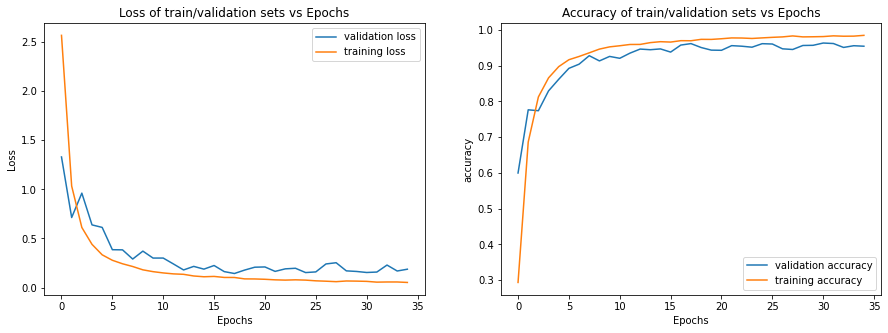

In [73]:
plot_model(history_gray_un_eq)

***As you can see, the model that has been trained on unequalized images is suffering from overfitting.***


***Also you'll see that it's accuracy is lower than the equalized version.***


In [74]:
model_gray_un_eq.evaluate(test_x_gray,test_y)

12630/12630 [==============================] - 1s 94us/sample - loss: 0.2057 - accuracy: 0.9630


[0.2057022915544259, 0.96302456]

#### 2) Model with image equalization on gray pictures :

In [75]:
model_gray_eq=model_config(eq_train_x_gray)

comp(model_gray_eq,0.0085,'sgd')

history_gray_eq=fit_model(model_gray_eq,train_generator_gray_eq,valid_generator_gray_eq,False, 'gray_eq')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1087 steps, validate for 137 steps
Epoch 1/35
1087/1087 [==============================] - 10s 9ms/step - loss: 2.1467 - accuracy: 0.3881 - val_loss: 1.0530 - val_accuracy: 0.6761
Epoch 2/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.9333 - accuracy: 0.7129 - val_loss: 0.5914 - val_accuracy: 0.8132
Epoch 3/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.5822 - accuracy: 0.8180 - val_loss: 0.5676 - val_accuracy: 0.8444
Epoch 4/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.4241 - accuracy: 0.8692 - val_loss: 0.3108 - val_accuracy: 0.9035
Epoch 5/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.3370 - accuracy: 0.8976 - val_loss: 0.3194 - val_accuracy: 0.9049
Epoch 6/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.2957 - accuracy: 0.9093 - val_loss: 0.2908 - val_accuracy: 0.9138
Epoch 7/35
1087/1087 [==================

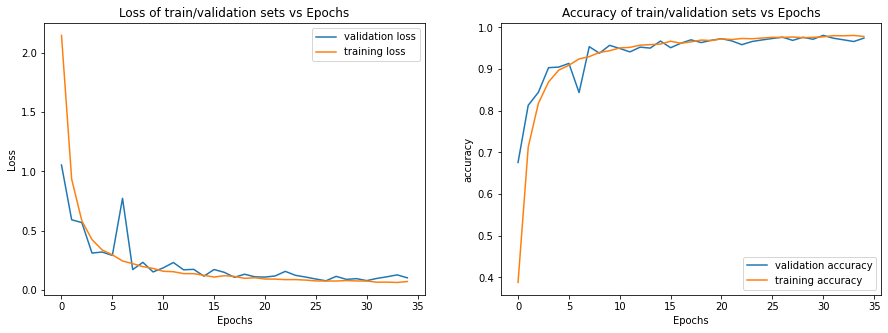

In [76]:
plot_model(history_gray_eq)

In [77]:
model_gray_eq.evaluate(eq_test_x_gray,test_y)

12630/12630 [==============================] - 1s 94us/sample - loss: 0.1526 - accuracy: 0.9665


[0.15257319786966195, 0.9665083]

***So far we found out the model with equalized images have a better performance.***

***It almost does not over fit and has a better performance on the unseen data. So from now on, we'll use the equalized images as a default setting.***

***Let's see the performance of a weighted model with equalized gray images.***

#### 3) Model with weighted labels on equalized gray images :

In [82]:
model_with_class_weights_gray=model_config(eq_train_x_gray)

comp(model_with_class_weights_gray,0.0085,'sgd')

history_with_class_weights_gray=fit_model(model_with_class_weights_gray,train_generator_gray_eq,valid_generator_gray_eq,True,'gray_with_class_weights')


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1087 steps, validate for 137 steps
Epoch 1/35
1087/1087 [==============================] - 10s 9ms/step - loss: 3.0467 - accuracy: 0.1642 - val_loss: 3.4222 - val_accuracy: 0.2340
Epoch 2/35
1087/1087 [==============================] - 10s 9ms/step - loss: 1.7604 - accuracy: 0.4420 - val_loss: 1.3569 - val_accuracy: 0.6405
Epoch 3/35
1087/1087 [==============================] - 10s 9ms/step - loss: 1.0356 - accuracy: 0.6431 - val_loss: 0.9646 - val_accuracy: 0.8125
Epoch 4/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.7139 - accuracy: 0.7484 - val_loss: 1.7907 - val_accuracy: 0.6911
Epoch 5/35
1087/1087 [==============================] - 10s 9ms/step - loss: 0.5042 - accuracy: 0.8196 - val_loss: 0.6870 - val_accuracy: 0.8675
Epoch 6/35
1087/1087 [==============================] - 9s 9ms/step - loss: 0.4294 - accuracy: 0.8466 - val_loss: 0.8238 - val_accuracy: 0.8622
Epoch 7/35
1087/1087 [===============

In [79]:
'''
model_with_class_weights.save_weights("gray_class_weights_traffic_signs_weights.h5")
model_with_class_weights.save("gray_class_weights_traffic_signs_model.h5")
'''

'\nmodel_with_class_weights.save_weights("gray_class_weights_traffic_signs_weights.h5")\nmodel_with_class_weights.save("gray_class_weights_traffic_signs_model.h5")\n'

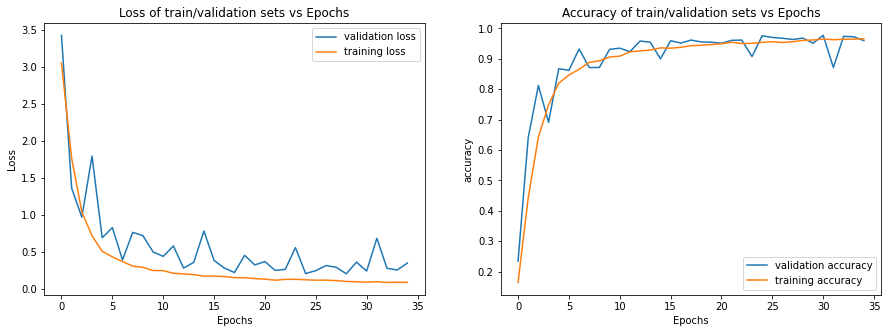

In [83]:
plot_model(history_with_class_weights_gray)

In [84]:
model_with_class_weights_gray.evaluate(eq_test_x_gray,test_y)

12630/12630 [==============================] - 1s 106us/sample - loss: 0.2504 - accuracy: 0.9544


[0.2503583237409344, 0.9543943]

***As you can see, the performance got slighty worse!***

#### 4) Model with image equalization on rgb pictures :

In [85]:
model_rgb_eq=model_config(eq_train_x_rgb)

comp(model_rgb_eq,0.0085,'sgd')

history_rgb_eq=fit_model(model_rgb_eq,train_generator_rgb_eq,valid_generator_rgb_eq,False,'rgb')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1087 steps, validate for 137 steps
Epoch 1/35
1087/1087 [==============================] - 16s 15ms/step - loss: 1.8682 - accuracy: 0.4510 - val_loss: 0.8931 - val_accuracy: 0.7404
Epoch 2/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.7518 - accuracy: 0.7671 - val_loss: 0.3762 - val_accuracy: 0.8707
Epoch 3/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.4440 - accuracy: 0.8634 - val_loss: 0.2942 - val_accuracy: 0.9129
Epoch 4/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.3162 - accuracy: 0.9014 - val_loss: 0.2341 - val_accuracy: 0.9254
Epoch 5/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.2448 - accuracy: 0.9230 - val_loss: 0.1594 - val_accuracy: 0.9548
Epoch 6/35
1087/1087 [==============================] - 15s 14ms/step - loss: 0.2041 - accuracy: 0.9357 - val_loss: 0.2375 - val_accuracy: 0.9275
Epoch 7/35
1087/1087 [=======

In [151]:
'''
model_rgb.save_weights("rgb_traffic_signs_weights.h5")
model_rgb.save("rgb_traffic_signs_model.h5")
'''

'\nmodel_rgb.save_weights("rgb_traffic_signs_weights.h5")\nmodel_rgb.save("rgb_traffic_signs_model.h5")\n'

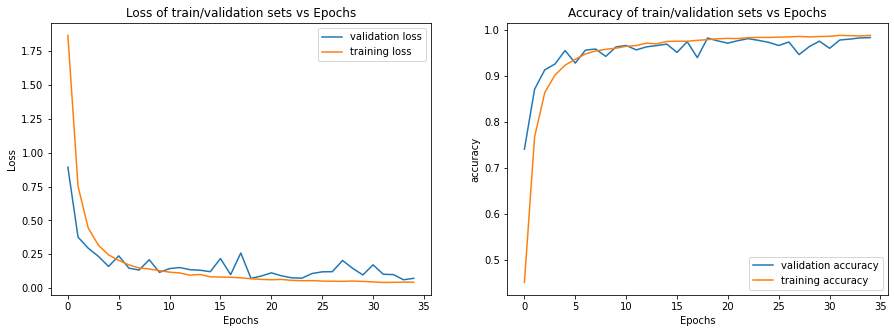

In [86]:
plot_model(history_rgb_eq)

In [87]:
model_rgb_eq.evaluate(eq_test_x_rgb ,test_y)

12630/12630 [==============================] - 2s 125us/sample - loss: 0.1119 - accuracy: 0.9749


[0.11186383391844563, 0.974901]

***As you can see, model with rgb equalized image will overfit a little bit but it's performance is better than the gray version.***


***So, we conclude that the best set of inputs is the rgb equalized images without any weight classes.***

#### 5) Model with weighted labels on equalized rgb images

For the sake of the discussion we'll try one last model on equalized rgb images with weighted classes to see what will happen.

In [88]:
model_rgb_eq_weight=model_config(eq_train_x_rgb)

comp(model_rgb_eq_weight,0.0085,'sgd')

history_rgb_eq_weight=fit_model(model_rgb_eq_weight,train_generator_rgb_eq,valid_generator_rgb_eq,True,'rgb')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1087 steps, validate for 137 steps
Epoch 1/35
1087/1087 [==============================] - 16s 15ms/step - loss: 2.8215 - accuracy: 0.2134 - val_loss: 2.3931 - val_accuracy: 0.4297
Epoch 2/35
1087/1087 [==============================] - 16s 15ms/step - loss: 1.5555 - accuracy: 0.4836 - val_loss: 1.3707 - val_accuracy: 0.6556
Epoch 3/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.9347 - accuracy: 0.6541 - val_loss: 0.9063 - val_accuracy: 0.7826
Epoch 4/35
1087/1087 [==============================] - 16s 15ms/step - loss: 0.6148 - accuracy: 0.7676 - val_loss: 0.8852 - val_accuracy: 0.8292
Epoch 5/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.4869 - accuracy: 0.8172 - val_loss: 0.5030 - val_accuracy: 0.8901
Epoch 6/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.3666 - accuracy: 0.8567 - val_loss: 0.3895 - val_accuracy: 0.9204
Epoch 7/35
1087/1087 [=======

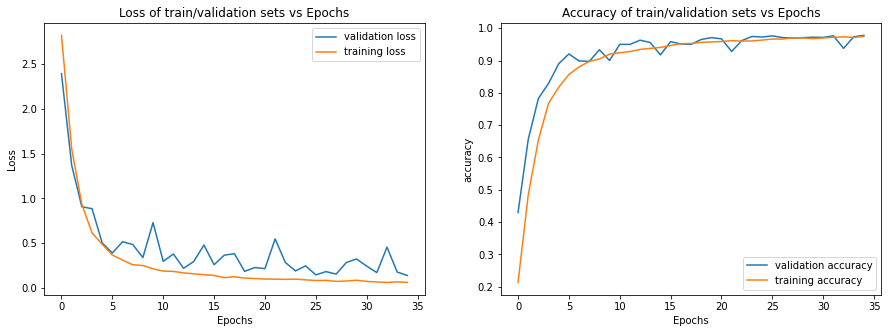

In [89]:
plot_model(history_rgb_eq_weight)

In [90]:
model_rgb_eq_weight.evaluate(eq_test_x_rgb ,test_y)

12630/12630 [==============================] - 1s 117us/sample - loss: 0.1755 - accuracy: 0.9620


[0.17549489408224553, 0.96199524]

As you can see, the performance didn't get any better, and the model is overfitting. So, we'll continue with the previous model.

_______________________________

# Tunnig the model without weighted labels, on equalized rgb images :

##### 1) adam with learning rate 0.001

In [91]:
model_rgb_eq_test1=model_config(eq_train_x_rgb)

comp(model_rgb_eq_test1,0.001,'adam')

history_rgb_eq_test1=fit_model(model_rgb_eq_test1,train_generator_rgb_eq,valid_generator_rgb_eq,False,'rgb')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1087 steps, validate for 137 steps
Epoch 1/35
1087/1087 [==============================] - 16s 15ms/step - loss: 1.6462 - accuracy: 0.5233 - val_loss: 0.6960 - val_accuracy: 0.7803
Epoch 2/35
1087/1087 [==============================] - 16s 15ms/step - loss: 0.5419 - accuracy: 0.8235 - val_loss: 0.3501 - val_accuracy: 0.8869
Epoch 3/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.3372 - accuracy: 0.8934 - val_loss: 0.2588 - val_accuracy: 0.9188
Epoch 4/35
1087/1087 [==============================] - 15s 14ms/step - loss: 0.2569 - accuracy: 0.9193 - val_loss: 0.3125 - val_accuracy: 0.9161
Epoch 5/35
1087/1087 [==============================] - 15s 14ms/step - loss: 0.2144 - accuracy: 0.9316 - val_loss: 0.4825 - val_accuracy: 0.8896
Epoch 6/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.1915 - accuracy: 0.9406 - val_loss: 0.2445 - val_accuracy: 0.9316
Epoch 7/35
1087/1087 [=======

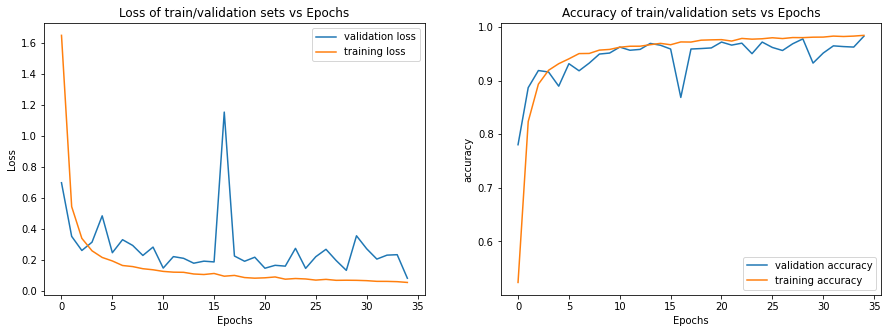

In [92]:
plot_model(history_rgb_eq_test1)

In [93]:
model_rgb_eq_test1.evaluate(eq_test_x_rgb ,test_y)

12630/12630 [==============================] - 1s 118us/sample - loss: 0.1638 - accuracy: 0.9741


[0.16378644712854637, 0.9741093]

***Apparently learning rate of 0.001 is worth than 0.0085***

##### 2) adam with learning rate 0.0025

In [94]:
model_rgb_eq_test2=model_config(eq_train_x_rgb)

comp(model_rgb_eq_test2,0.0025,'adam')

history_rgb_eq_test2=fit_model(model_rgb_eq_test2,train_generator_rgb_eq,valid_generator_rgb_eq,False,'rgb')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1087 steps, validate for 137 steps
Epoch 1/35
1087/1087 [==============================] - 16s 15ms/step - loss: 1.6618 - accuracy: 0.5092 - val_loss: 1.1159 - val_accuracy: 0.6813
Epoch 2/35
1087/1087 [==============================] - 16s 15ms/step - loss: 0.6885 - accuracy: 0.7826 - val_loss: 0.6827 - val_accuracy: 0.8123
Epoch 3/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.4442 - accuracy: 0.8608 - val_loss: 0.4235 - val_accuracy: 0.9067
Epoch 4/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.3554 - accuracy: 0.8910 - val_loss: 0.4467 - val_accuracy: 0.9053
Epoch 5/35
1087/1087 [==============================] - 16s 15ms/step - loss: 0.3027 - accuracy: 0.9090 - val_loss: 0.3078 - val_accuracy: 0.9231
Epoch 6/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.2525 - accuracy: 0.9227 - val_loss: 0.3076 - val_accuracy: 0.9416
Epoch 7/35
1087/1087 [=======

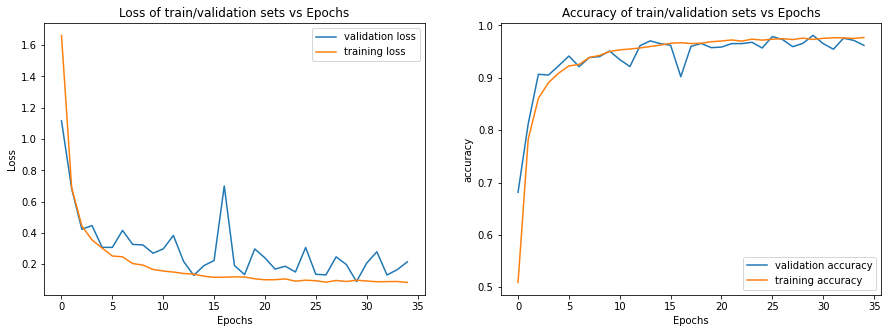

In [95]:
plot_model(history_rgb_eq_test2)

In [162]:
model_rgb_eq_test2.evaluate(eq_test_x_rgb ,test_y)

395/395 [==============================] - 1s 3ms/step - loss: 0.2663 - accuracy: 0.9529


[0.26626887917518616, 0.9528899192810059]

***The above model is worse than the base model***

##### 3) adam with learning rate 0.005

In [96]:
model_rgb_eq_test3=model_config(eq_train_x_rgb)

comp(model_rgb_eq_test3,0.005,'adam')

history_rgb_eq_test3=fit_model(model_rgb_eq_test3,train_generator_rgb_eq,valid_generator_rgb_eq,False,'rgb')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1087 steps, validate for 137 steps
Epoch 1/35
1087/1087 [==============================] - 16s 15ms/step - loss: 2.1770 - accuracy: 0.3555 - val_loss: 2.3179 - val_accuracy: 0.4913
Epoch 2/35
1087/1087 [==============================] - 16s 15ms/step - loss: 1.1315 - accuracy: 0.6336 - val_loss: 1.6483 - val_accuracy: 0.6896
Epoch 3/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.7242 - accuracy: 0.7727 - val_loss: 0.4972 - val_accuracy: 0.8711
Epoch 4/35
1087/1087 [==============================] - 15s 14ms/step - loss: 0.5271 - accuracy: 0.8363 - val_loss: 0.6701 - val_accuracy: 0.8426
Epoch 5/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.4346 - accuracy: 0.8666 - val_loss: 0.3145 - val_accuracy: 0.9240
Epoch 6/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.3881 - accuracy: 0.8843 - val_loss: 0.3111 - val_accuracy: 0.9259
Epoch 7/35
1087/1087 [=======

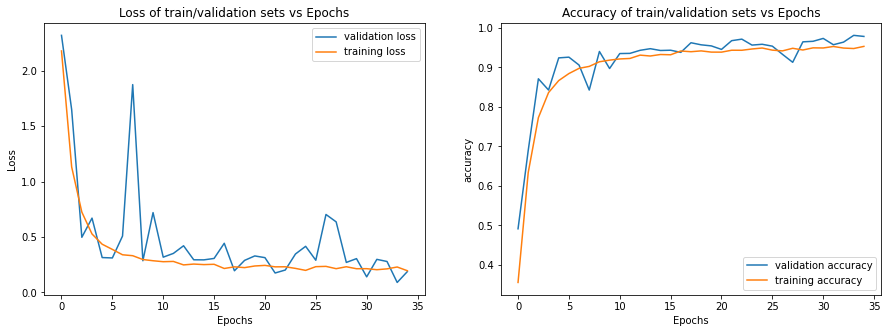

In [97]:
plot_model(history_rgb_eq_test3)

In [98]:
model_rgb_eq_test3.evaluate(eq_test_x_rgb ,test_y)

12630/12630 [==============================] - 1s 102us/sample - loss: 0.2242 - accuracy: 0.9747


[0.22421738962968701, 0.97474265]

***So far, adam optimizer didn't show any better performance compare to the sgd optimizer of the base model. So, we'll switch to sgd and will try to tune it's learning rate.***

##### 4) sgd with learning rate 0.001

In [99]:
model_rgb_eq_test4=model_config(eq_train_x_rgb)

comp(model_rgb_eq_test4,0.001,'sgd')

history_rgb_eq_test4=fit_model(model_rgb_eq_test4,train_generator_rgb_eq,valid_generator_rgb_eq,False,'rgb')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1087 steps, validate for 137 steps
Epoch 1/35
1087/1087 [==============================] - 16s 15ms/step - loss: 2.2596 - accuracy: 0.3804 - val_loss: 1.3877 - val_accuracy: 0.5828
Epoch 2/35
1087/1087 [==============================] - 16s 14ms/step - loss: 1.1854 - accuracy: 0.6279 - val_loss: 0.8843 - val_accuracy: 0.7260
Epoch 3/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.7191 - accuracy: 0.7696 - val_loss: 0.5526 - val_accuracy: 0.8114
Epoch 4/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.5007 - accuracy: 0.8398 - val_loss: 0.3325 - val_accuracy: 0.8946
Epoch 5/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.3797 - accuracy: 0.8793 - val_loss: 0.3589 - val_accuracy: 0.8951
Epoch 6/35
1087/1087 [==============================] - 15s 14ms/step - loss: 0.3139 - accuracy: 0.8990 - val_loss: 0.3029 - val_accuracy: 0.8926
Epoch 7/35
1087/1087 [=======

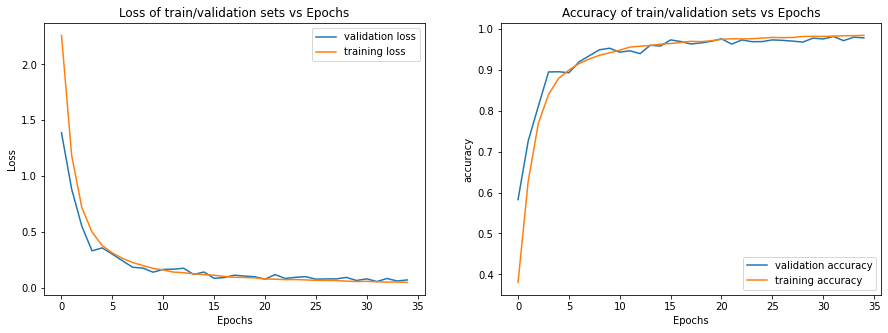

In [100]:
plot_model(history_rgb_eq_test4)

In [102]:
model_rgb_eq_test4.evaluate(eq_test_x_rgb ,test_y)

12630/12630 [==============================] - 1s 104us/sample - loss: 0.0987 - accuracy: 0.9724


[0.09873557294263952, 0.97244656]

##### 5) sgd with learning rate 0.005

In [103]:
model_rgb_eq_test5=model_config(eq_train_x_rgb)

comp(model_rgb_eq_test5,0.005,'sgd')

history_rgb_eq_test5=fit_model(model_rgb_eq_test5,train_generator_rgb_eq,valid_generator_rgb_eq,False,'rgb')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1087 steps, validate for 137 steps
Epoch 1/35
1087/1087 [==============================] - 16s 15ms/step - loss: 1.7873 - accuracy: 0.4814 - val_loss: 0.9390 - val_accuracy: 0.7172
Epoch 2/35
1087/1087 [==============================] - 16s 15ms/step - loss: 0.7214 - accuracy: 0.7690 - val_loss: 0.4039 - val_accuracy: 0.8675
Epoch 3/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.4388 - accuracy: 0.8588 - val_loss: 0.3409 - val_accuracy: 0.8923
Epoch 4/35
1087/1087 [==============================] - 16s 15ms/step - loss: 0.3221 - accuracy: 0.8994 - val_loss: 0.2335 - val_accuracy: 0.9236
Epoch 5/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.2510 - accuracy: 0.9204 - val_loss: 0.2281 - val_accuracy: 0.9297
Epoch 6/35
1087/1087 [==============================] - 16s 15ms/step - loss: 0.2046 - accuracy: 0.9342 - val_loss: 0.1914 - val_accuracy: 0.9418
Epoch 7/35
1087/1087 [=======

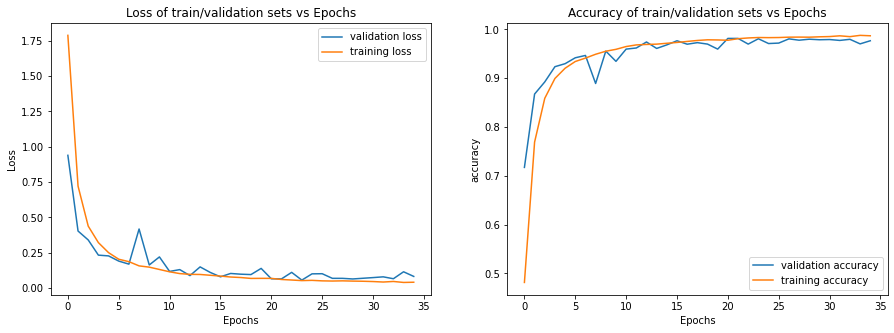

In [104]:
plot_model(history_rgb_eq_test5)

In [105]:
model_rgb_eq_test5.evaluate(eq_test_x_rgb ,test_y)

12630/12630 [==============================] - 1s 101us/sample - loss: 0.1211 - accuracy: 0.9733


[0.12113127082807609, 0.9733175]

##### 6) sgd with learning rate 0.0065

In [106]:
model_rgb_eq_test6=model_config(eq_train_x_rgb)

comp(model_rgb_eq_test6,0.0065,'sgd')

history_rgb_eq_test6=fit_model(model_rgb_eq_test6,train_generator_rgb_eq,valid_generator_rgb_eq,False,'rgb')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1087 steps, validate for 137 steps
Epoch 1/35
1087/1087 [==============================] - 16s 15ms/step - loss: 2.0508 - accuracy: 0.4120 - val_loss: 1.3413 - val_accuracy: 0.5839
Epoch 2/35
1087/1087 [==============================] - 16s 15ms/step - loss: 0.8779 - accuracy: 0.7168 - val_loss: 0.6022 - val_accuracy: 0.8095
Epoch 3/35
1087/1087 [==============================] - 16s 15ms/step - loss: 0.5196 - accuracy: 0.8340 - val_loss: 0.4958 - val_accuracy: 0.8424
Epoch 4/35
1087/1087 [==============================] - 16s 15ms/step - loss: 0.3717 - accuracy: 0.8826 - val_loss: 0.4475 - val_accuracy: 0.8627
Epoch 5/35
1087/1087 [==============================] - 16s 15ms/step - loss: 0.2809 - accuracy: 0.9106 - val_loss: 0.2468 - val_accuracy: 0.9181
Epoch 6/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.2373 - accuracy: 0.9263 - val_loss: 0.5123 - val_accuracy: 0.8613
Epoch 7/35
1087/1087 [=======

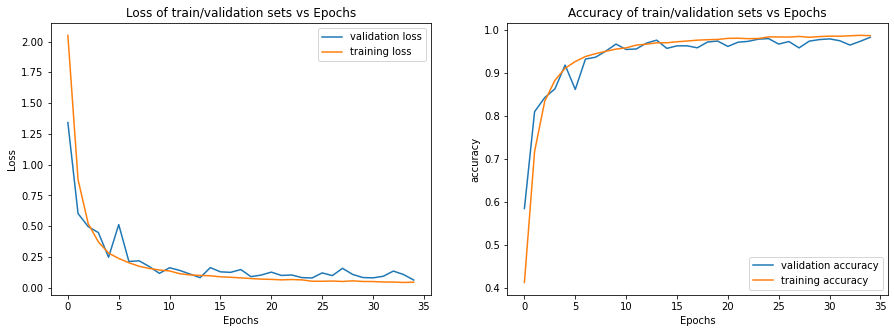

In [107]:
plot_model(history_rgb_eq_test6)

In [109]:
model_rgb_eq_test6.evaluate(eq_test_x_rgb ,test_y)

12630/12630 [==============================] - 1s 104us/sample - loss: 0.1328 - accuracy: 0.9724


[0.13276184521300946, 0.97244656]

##### 7) sgd with learning rate 0.007

In [110]:
model_rgb_eq_test7=model_config(eq_train_x_rgb)

comp(model_rgb_eq_test7,0.007,'sgd')

history_rgb_eq_test7=fit_model(model_rgb_eq_test7,train_generator_rgb_eq,valid_generator_rgb_eq,False,'rgb')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1087 steps, validate for 137 steps
Epoch 1/35
1087/1087 [==============================] - 16s 15ms/step - loss: 1.9512 - accuracy: 0.4344 - val_loss: 0.9866 - val_accuracy: 0.6581
Epoch 2/35
1087/1087 [==============================] - 16s 15ms/step - loss: 0.8062 - accuracy: 0.7422 - val_loss: 0.5252 - val_accuracy: 0.8337
Epoch 3/35
1087/1087 [==============================] - 16s 15ms/step - loss: 0.4844 - accuracy: 0.8479 - val_loss: 0.3269 - val_accuracy: 0.8905
Epoch 4/35
1087/1087 [==============================] - 16s 15ms/step - loss: 0.3412 - accuracy: 0.8937 - val_loss: 0.2195 - val_accuracy: 0.9386
Epoch 5/35
1087/1087 [==============================] - 15s 14ms/step - loss: 0.2681 - accuracy: 0.9162 - val_loss: 0.2214 - val_accuracy: 0.9361
Epoch 6/35
1087/1087 [==============================] - 15s 14ms/step - loss: 0.2240 - accuracy: 0.9294 - val_loss: 0.2374 - val_accuracy: 0.9323
Epoch 7/35
1087/1087 [=======

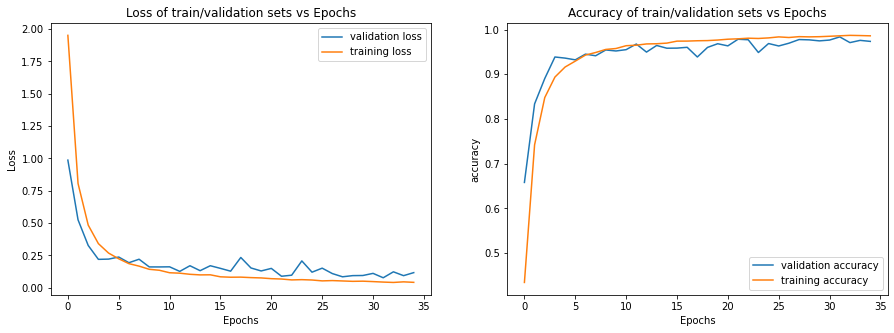

In [111]:
plot_model(history_rgb_eq_test7)

In [112]:
model_rgb_eq_test7.evaluate(eq_test_x_rgb ,test_y)

12630/12630 [==============================] - 1s 102us/sample - loss: 0.1641 - accuracy: 0.9679


[0.16413894029858384, 0.9678543]

##### 8) sgd with learning rate 0.008

In [113]:
model_rgb_eq_test8=model_config(eq_train_x_rgb)

comp(model_rgb_eq_test8,0.008,'sgd')

history_rgb_eq_test8=fit_model(model_rgb_eq_test8,train_generator_rgb_eq,valid_generator_rgb_eq,False,'rgb')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 1087 steps, validate for 137 steps
Epoch 1/35
1087/1087 [==============================] - 16s 15ms/step - loss: 1.9170 - accuracy: 0.4445 - val_loss: 1.2936 - val_accuracy: 0.6325
Epoch 2/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.8441 - accuracy: 0.7330 - val_loss: 0.4590 - val_accuracy: 0.8604
Epoch 3/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.5209 - accuracy: 0.8367 - val_loss: 0.4012 - val_accuracy: 0.8718
Epoch 4/35
1087/1087 [==============================] - 15s 14ms/step - loss: 0.3808 - accuracy: 0.8797 - val_loss: 0.4682 - val_accuracy: 0.8597
Epoch 5/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.3031 - accuracy: 0.9077 - val_loss: 0.2623 - val_accuracy: 0.9193
Epoch 6/35
1087/1087 [==============================] - 16s 14ms/step - loss: 0.2464 - accuracy: 0.9235 - val_loss: 0.2236 - val_accuracy: 0.9364
Epoch 7/35
1087/1087 [=======

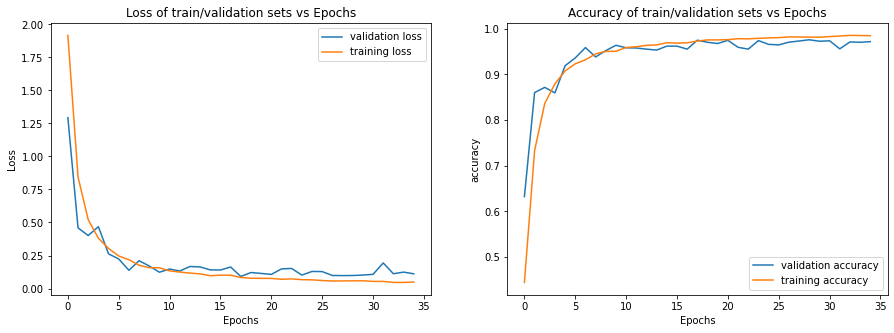

In [114]:
plot_model(history_rgb_eq_test8)

In [115]:
model_rgb_eq_test8.evaluate(eq_test_x_rgb ,test_y)

12630/12630 [==============================] - 1s 101us/sample - loss: 0.1749 - accuracy: 0.9648


[0.17487664310310713, 0.96476644]

***So, the best learning rate is 0.001***

***Let's save the best model***

In [116]:
model_rgb_eq_test4.save_weights("best_model_weights.h5")
model_rgb_eq_test4.save("best_model_MODEL.h5")

________________

# Visualizing the output of each conv layer for a specific image :

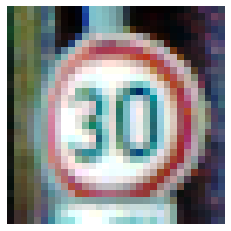

In [122]:
### visualizing the image that we will use later to see each layer's output
plt.imshow(eq_test_x_rgb[1],cmap='gray')
plt.axis('off')
plt.show()

In [123]:
### extracting the indexes of conv layers
ln=[]
i=0
for layer in model_rgb_eq_test4.layers:
    i=i+1
    if 'conv' not in layer.name:
        continue
    ln.append((i-1))
    
ln  

[1, 5, 9]

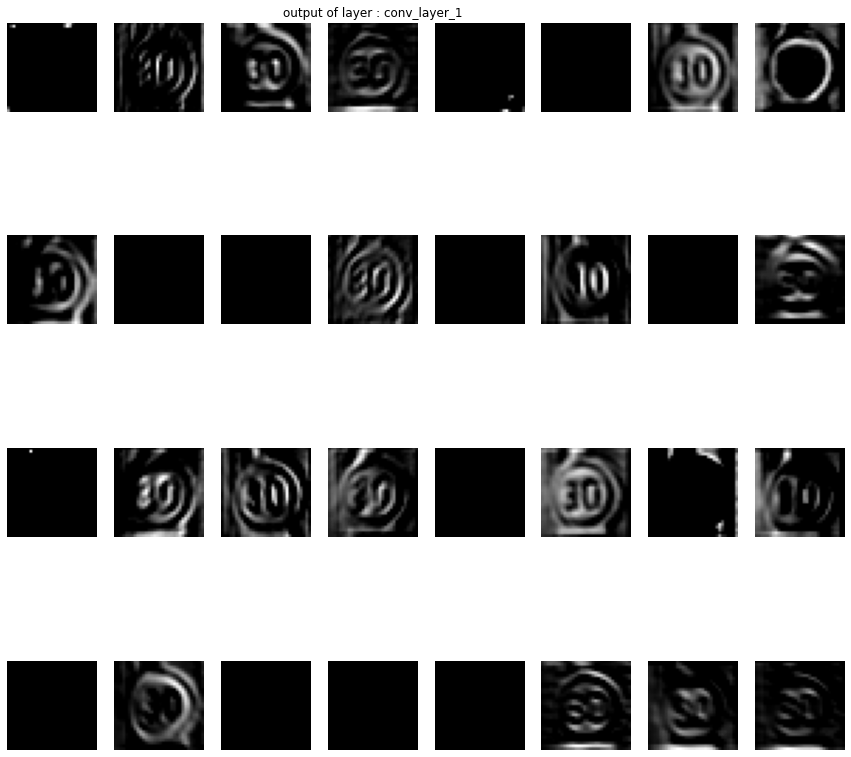

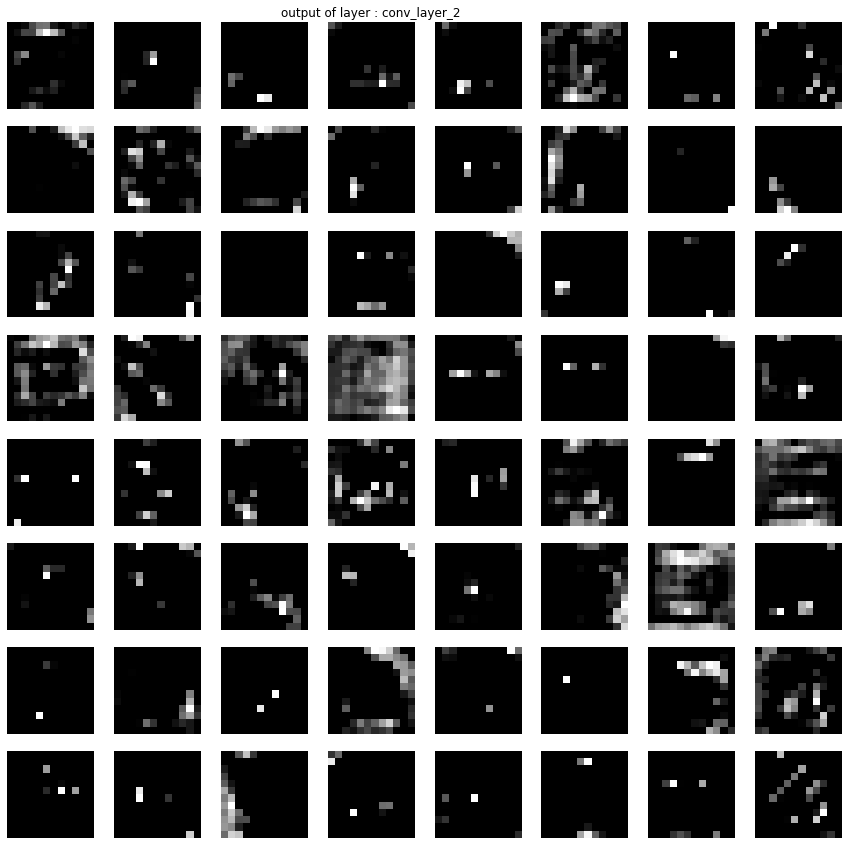

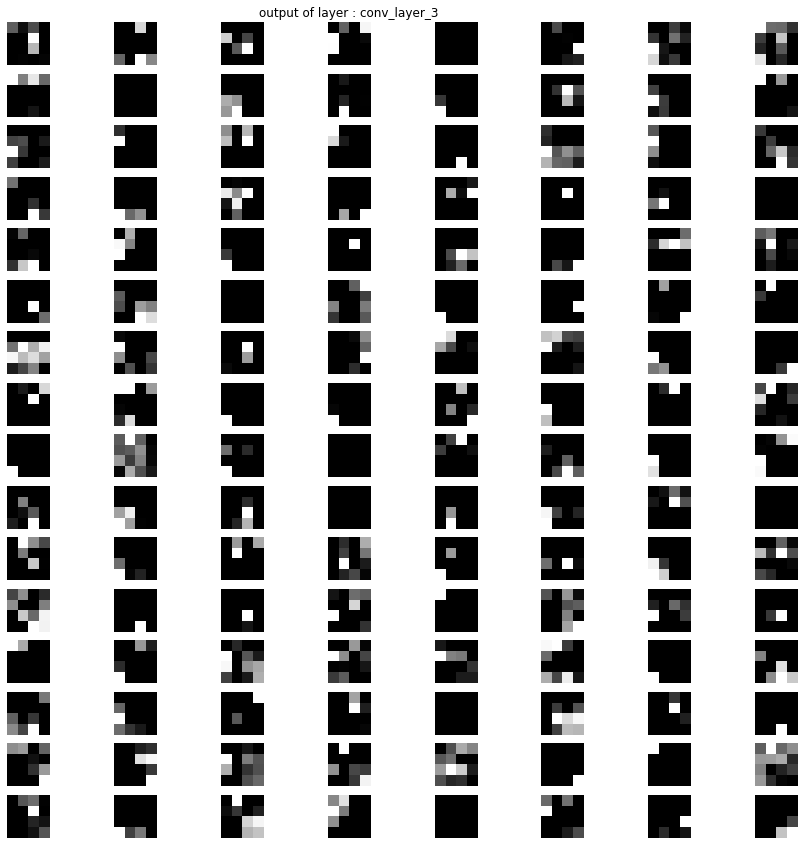

In [128]:
###visualizing conv layers outputs
for n_layer in ln:
    
    model_layer = Model(inputs=model_rgb_eq_test4.inputs, outputs=model_rgb_eq_test4.layers[n_layer].output)
    feature_maps = model_layer.predict(eq_test_x_rgb[1].reshape(1,32,32,3))  
    n_col=8
    n_row=feature_maps.shape[-1]//8
    fig, axs = plt.subplots(n_row , n_col,figsize=(15,15))
    i=0
    for j in range(n_row):
        j = tf.convert_to_tensor(j, dtype=tf.int64)
        for z in range(n_col):
            z = tf.convert_to_tensor(z, dtype=tf.int64)
            axs[j,z].imshow(feature_maps[0, :, :, i],cmap='gray')
            i=i+1
            axs[j,z].axis('off')
    axs[0,3].set_title(f"output of layer : {model_rgb_eq_test4.layers[n_layer].name}",loc='center')  
plt.show()

## Investigating some of the signs we mispredict :

In [129]:
pred=model_rgb_eq_test4.predict(eq_test_x_rgb)

indx=[]
wrong_pred_label=[]
right_label=[]



for i in range(0,len(test_y)):
    if np.argmax(pred[i])==np.argmax(test_y[i]):
        continue
    wrong_pred_label.append(np.argmax(pred[i]) )  ### an array of mispredict images containing the wrong labels
    right_label.append(np.argmax(test_y[i])) ###an array of mispredict images containing the right labels we failed to predict
    indx.append(i)  ###index of mispredict images in the test set
    
    
indx=np.array(indx)
wrong_pred_label=np.array(wrong_pred_label)
right_label=np.array(right_label)

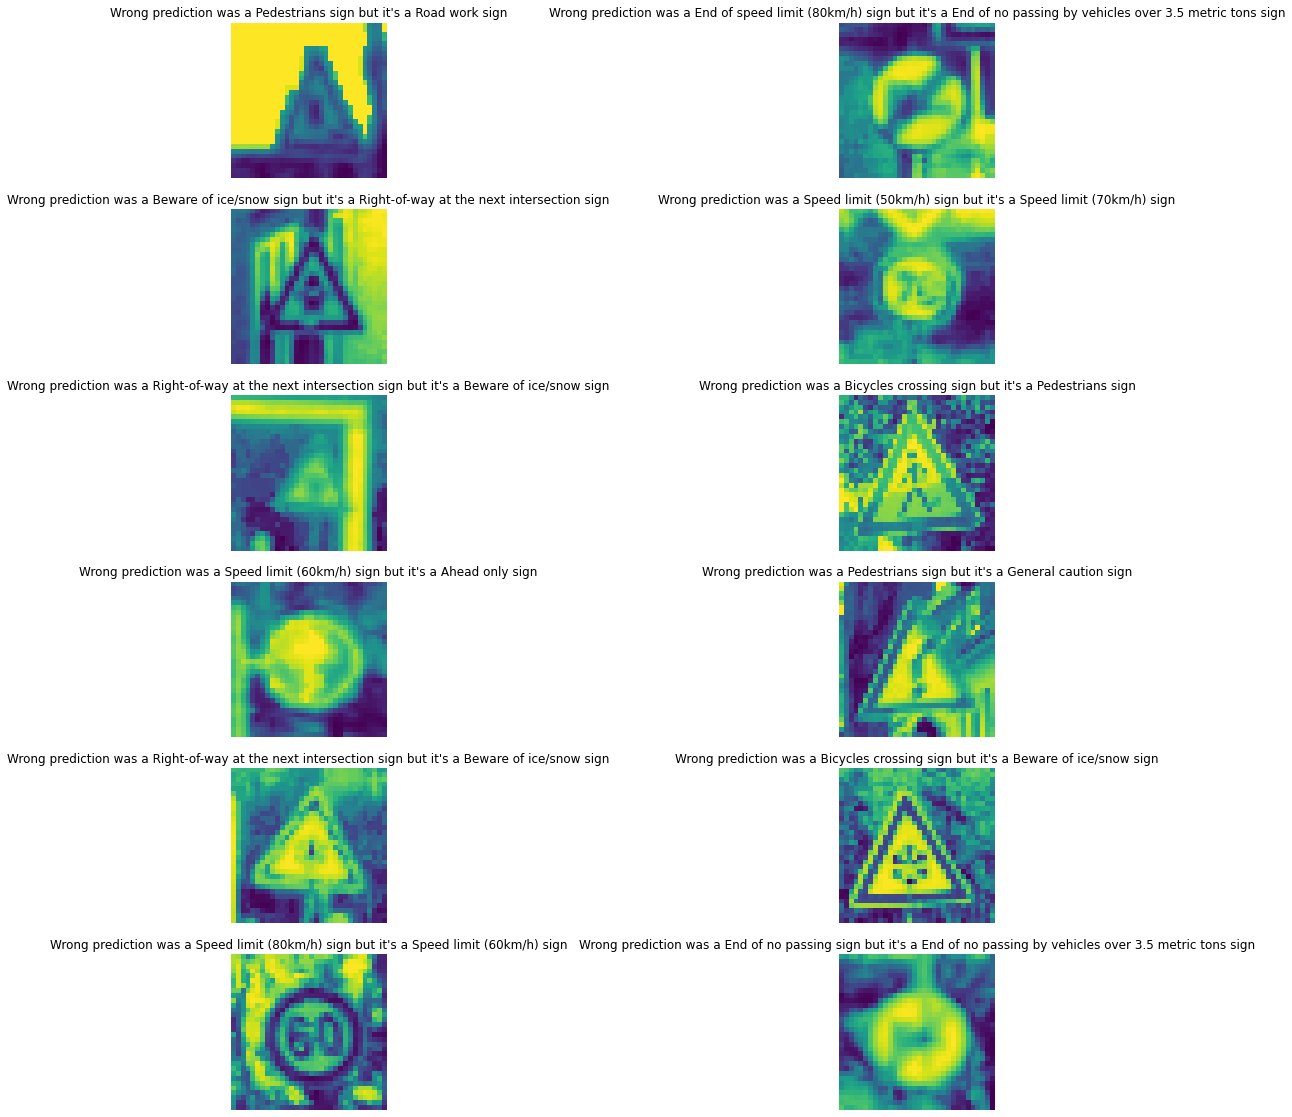

In [130]:
w=30
n_col=2
n_row=6
fig, axs = plt.subplots(n_row ,n_col,figsize=(20,20))
for i in range(n_row):
    for j in range(n_col):
        axs[i,j].imshow(eq_test_x_gray[indx[w],:,:,0])#,cmap='gray'
        axs[i,j].set_title(f"Wrong prediction was a {sign[sign['ClassId']==wrong_pred_label[w]]['SignName'].values[0]} sign but it's a {sign[sign['ClassId']==right_label[w]]['SignName'].values[0]} sign" )
        axs[i,j].axis('off')
        w=w+1
      

plt.show()

## Finding the most frequent mispredictions :

In [131]:
ddf=pd.DataFrame({'wrong_pred_label':wrong_pred_label,'right_label':right_label})
dff=ddf.groupby(['wrong_pred_label','right_label']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count', ascending=False)
dff

wrong_pred_label  right_label  count
67                27           18     28
8                  2            5     22
77                29           27     20
79                30           11     18
86                32            6     16
..               ...          ...    ...
50                20           31      1
52                21           30      1
53                22           31      1
58                25            5      1
98                42            6      1

[99 rows x 3 columns]

***As you can see, label 18 was 28 times wrogly predicted as label 27***

***Then it predicted label 5 a lebel 2 for 22 times***

***Also the network wrongly predicted label 27 a label 29 for 20 times***

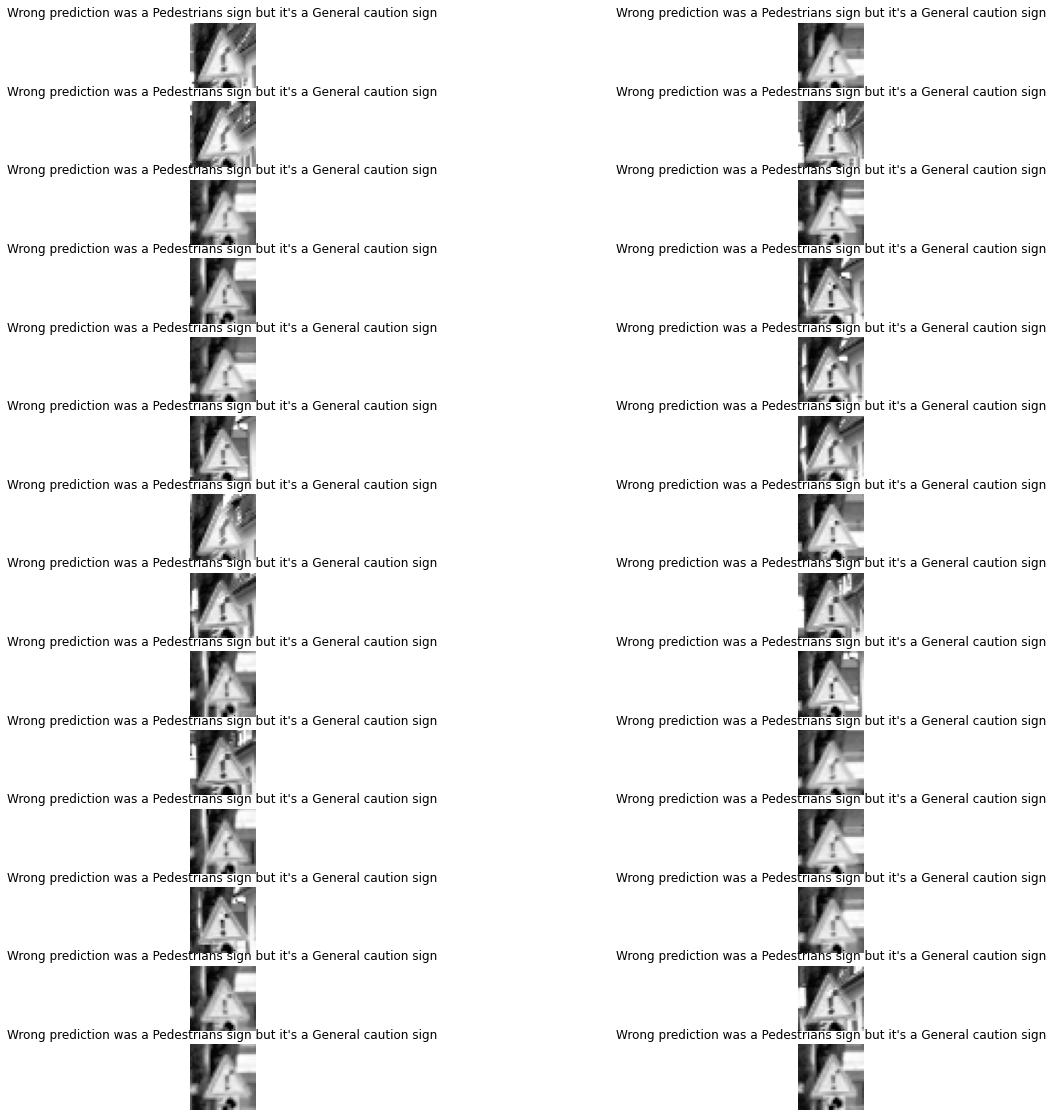

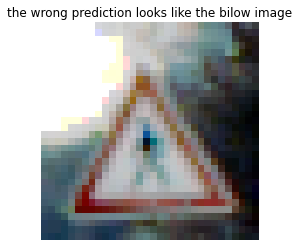

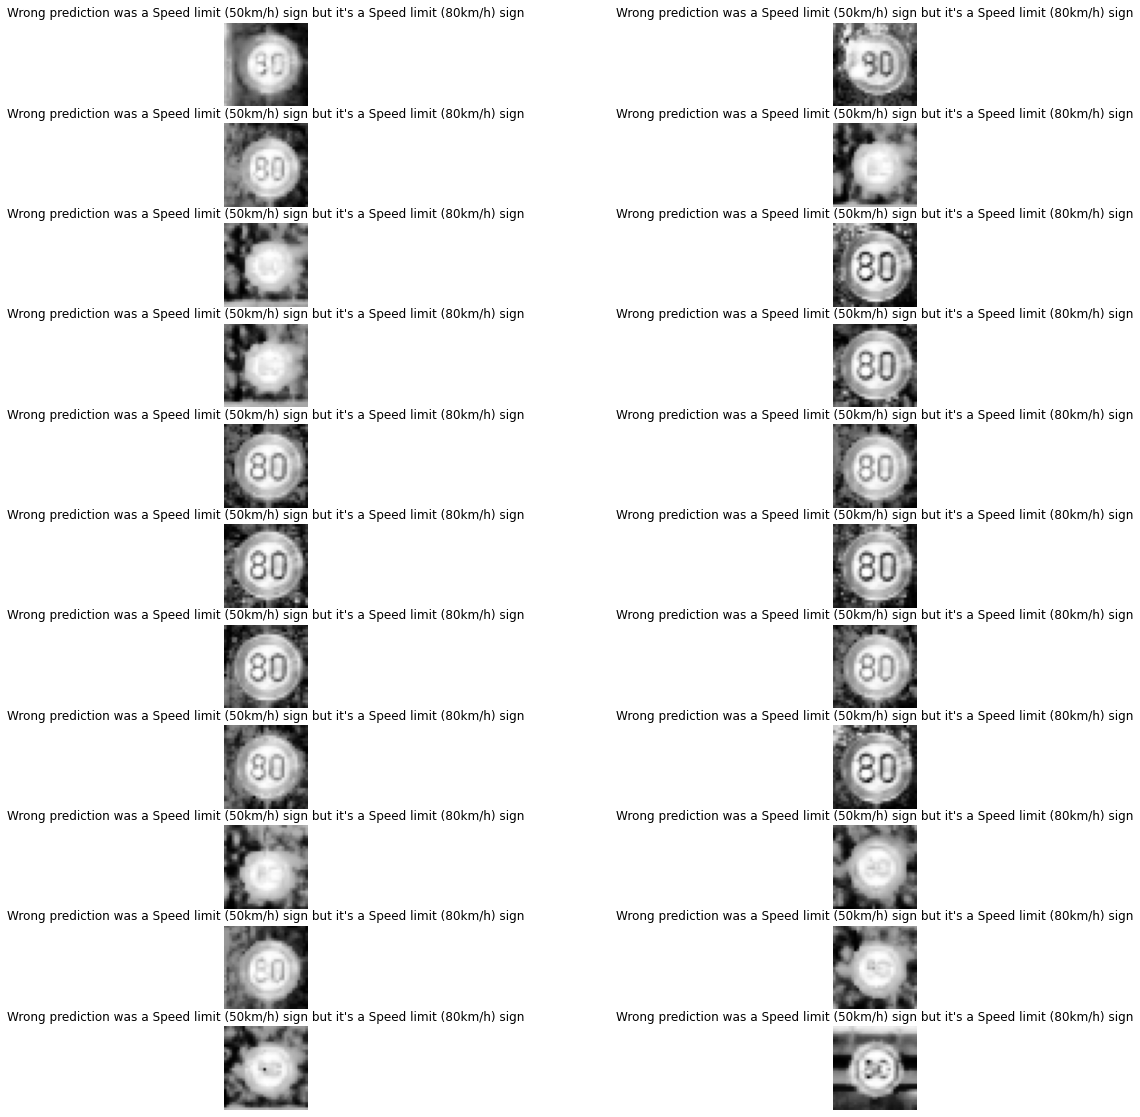

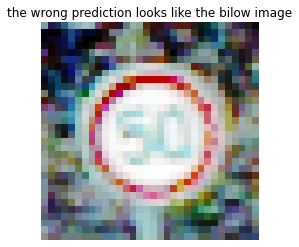

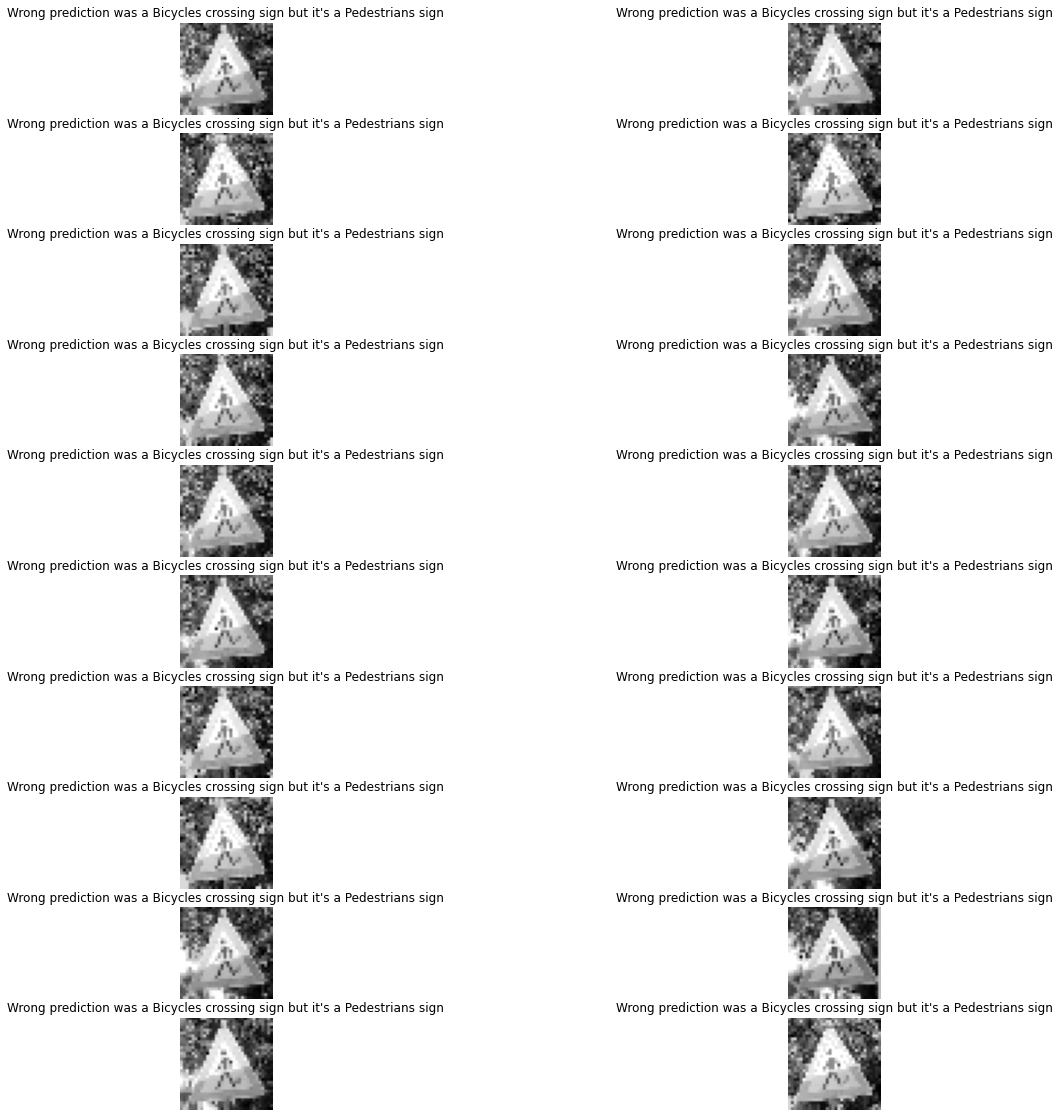

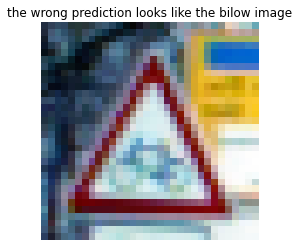

In [132]:
### plotting the three most frequent mistakes

for i in range(3):
    most_frequent_mis_pred=indx[(wrong_pred_label==dff['wrong_pred_label'].iloc[i]) & (right_label==dff['right_label'].iloc[i])]
    n_col=2
    n_row=len(most_frequent_mis_pred)//n_col
    w=0
    fig, axs = plt.subplots(n_row ,n_col ,figsize=(20,20))
    for i in range(n_row):
        for j in range(n_col):
            temp_index=most_frequent_mis_pred[w]
      
            axs[i,j].imshow(eq_test_x_rgb[temp_index,:,:,0],cmap='gray')
            axs[i,j].set_title(f"Wrong prediction was a {sign[sign['ClassId']==wrong_pred_label[np.where(indx==temp_index)[0][0]]]['SignName'].values[0]} sign but it's a {sign[sign['ClassId']==right_label[np.where(indx==temp_index)[0][0]]]['SignName'].values[0]} sign" )
            w=w+1
            axs[i,j].axis('off')
    plt.show()
    wrng_pred_indx=np.where(np.argmax(test_y,axis=1)==wrong_pred_label[np.where(indx==temp_index)[0][0]])[0][19]
    plt.imshow(eq_test_x_rgb[wrng_pred_indx],cmap='gray')
    plt.title('the wrong prediction looks like the bilow image')
    plt.axis('off')
    plt.show()
    print("\n")
    